In [ ]:
!pip install transformers

### Necessary packages

In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler
import torch.optim as optim

import os
import copy
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pylab import rcParams
import csv
import time
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from transformers import AutoTokenizer,AutoModel,AutoModelForSequenceClassification,AdamW,get_linear_schedule_with_warmup

seed_val = 42 
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Running on gpu",torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print('No GPU found Running on cpu')

Running on gpu Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_dir = "/content/drive/MyDrive/AmazonMLChallenge/dataset"

train_df = pd.read_csv(dataset_dir+"/train.csv",escapechar="\\",quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(dataset_dir+"/test.csv",escapechar="\\",quoting=csv.QUOTE_NONE)
sample_df = pd.read_csv(dataset_dir+"/sample_submission.csv",escapechar="\\",quoting=csv.QUOTE_NONE)

In [ ]:
train_df['TITLE'].isnull().sum()

71

In [ ]:
len(train_df)-len(train_df.drop_duplicates())

101494

In [ ]:
train_df.shape

(2903024, 5)

In [ ]:
train_df = train_df.drop_duplicates()
train_df.shape

(2801530, 5)

In [ ]:
train_df = train_df[train_df['TITLE'].notnull()]

In [ ]:
train_df['TITLE'].isnull().sum()

0

In [ ]:
le = LabelEncoder()
train_df['BROWSE_NODE_ID'] = le.fit_transform(train_df['BROWSE_NODE_ID'])
train_df['BROWSE_NODE_ID'].max()

9918

In [ ]:
sentences = train_df['TITLE'].values 
labels = train_df['BROWSE_NODE_ID'].values

In [ ]:
print(sentences.shape,labels.shape)

(2801467,) (2801467,)


In [ ]:
train_sentences,val_sentences,train_labels,val_labels = train_test_split(sentences,labels,test_size = 0.1,random_state=seed_val)

In [ ]:
print(f"No. of training sentences {len(train_sentences)}")
print(f"No. of validation sentences {len(val_sentences)}")

No. of training sentences 2521320
No. of validation sentences 280147


In [ ]:
train_df.memory_usage(deep= True)*(1e-6)

Index               22.411736
TITLE              410.878601
DESCRIPTION       1593.625925
BULLET_POINTS     1398.700015
BRAND              183.974600
BROWSE_NODE_ID      22.411736
dtype: float64

In [ ]:
indices , cnts = np.unique(labels,return_counts=True)

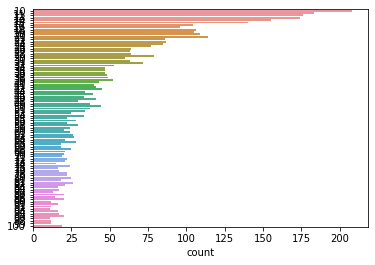

In [ ]:
sns.countplot(y = cnts[ (cnts >=10) & (cnts <=100)] )

In [ ]:
model_name = 'bert-base-multilingual-cased'
max_input_length = 128
batch_size = 64

### Data Preprocessing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
idx = 100000
sample_text = sentences[idx]
tokens =tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Sample text {}'.format(sample_text))
print('Tokens {}'.format(tokens))
print('Token IDS {}'.format(token_ids))

Sample text BANBERRY DESIGNS Cat Picture - Kittens in a Basket Poster - Wall Decor for Kids Room - Black Framed Picture Artwork - 3D Holographic Wall Art (Renewed)
Tokens ['BA', '##NB', '##ER', '##R', '##Y', 'DE', '##SI', '##G', '##NS', 'Cat', 'Picture', '-', 'Kit', '##tens', 'in', 'a', 'Basket', 'Post', '##er', '-', 'Wall', 'Dec', '##or', 'for', 'Kids', 'Room', '-', 'Black', 'Fram', '##ed', 'Picture', 'Art', '##work', '-', '3D', 'Ho', '##log', '##raphic', 'Wall', 'Art', '(', 'Rene', '##wed', ')']
Token IDS [39999, 53244, 24093, 11273, 14703, 25067, 44802, 11447, 69196, 25059, 29582, 118, 45301, 58513, 10106, 169, 51976, 14539, 10165, 118, 19523, 46147, 10667, 10142, 28151, 26512, 118, 11750, 68063, 10336, 29582, 11397, 37382, 118, 17280, 20220, 18007, 48532, 19523, 11397, 113, 91790, 48854, 114]


In [ ]:
tokenizer.sep_token,tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token,tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = max_input_length,
    add_special_tokens = True,
    pad_to_max_length=True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoding

{'input_ids': tensor([[  101, 39999, 53244, 24093, 11273, 14703, 25067, 44802, 11447, 69196,
         25059, 29582,   118, 45301, 58513, 10106,   169, 51976, 14539, 10165,
           118, 19523, 46147, 10667, 10142, 28151, 26512,   118, 11750, 68063,
         10336, 29582, 11397, 37382,   118, 17280, 20220, 18007, 48532, 19523,
         11397,   113, 91790, 48854,   114,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [ ]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
base_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
base_model(**encoding)['pooler_output']

tensor([[ 1.6638e-01, -2.2678e-01,  2.9962e-01, -1.6099e-01, -1.0810e-01,
          3.6077e-01,  2.8965e-01,  3.3004e-01, -5.0893e-01,  1.7437e-01,
         -1.8017e-01, -1.7017e-01, -2.0878e-01, -2.5722e-01,  2.0610e-01,
         -2.3200e-01,  5.7133e-01,  1.2473e-01,  1.7385e-01, -3.7577e-01,
         -9.9971e-01, -1.7423e-01, -3.3126e-01, -2.0555e-01, -2.0162e-01,
          2.7177e-01, -3.3592e-01,  1.6510e-01,  2.0183e-01, -2.2689e-01,
          1.4718e-01, -9.9972e-01,  7.0003e-01,  6.8122e-01,  1.6884e-01,
         -1.9151e-01,  3.0564e-01,  2.3276e-01,  2.3881e-01, -3.4318e-01,
         -1.5799e-01,  1.2846e-01, -2.2869e-01,  2.0420e-01,  9.5018e-03,
         -2.9154e-01, -1.3386e-01,  2.5103e-01, -2.2508e-01,  2.3263e-01,
          7.8671e-03,  1.0300e-01,  3.9618e-01,  2.6363e-01,  2.6938e-01,
          3.4279e-02,  2.7643e-01,  3.0324e-02,  4.1956e-01, -2.9954e-01,
         -2.2356e-02,  2.9602e-01,  2.5860e-01, -2.3699e-01, -2.1637e-01,
         -3.6217e-01,  4.4292e-02, -7.

## Choosing token length

In [ ]:
# token_lens = []
# for txt in sentences:
#     tokens = tokenizer.encode(txt,max_length=512)
#     token_lens.append(len(tokens))

In [ ]:
# sns.displot(token_lens)

In [ ]:
class AmazonDataset(Dataset):

  def __init__(self, sentences, labels, tokenizer, max_length,with_labels=True):
    self.sentences = sentences
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.with_labels = with_labels
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, idx):
    sentence = str(self.sentences[idx])
    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_length,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    if self.with_labels:
        
        label = self.labels[idx]

        return {
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    else:
        return {
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

In [ ]:
def create_data_loaders(sentences,labels,tokenizer,max_input_length,batch_size,with_labels):
    ds = AmazonDataset(
        sentences =sentences,
        labels=labels,
        tokenizer=tokenizer,
        max_length=max_input_length,
        with_labels = with_labels
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [ ]:
train_loader = create_data_loaders(
    train_sentences,
    train_labels,
    tokenizer,
    max_input_length=max_input_length,
    batch_size=batch_size,
    with_labels = True
)

val_loader = create_data_loaders(
    val_sentences,
    val_labels,
    tokenizer,
    max_input_length=max_input_length,
    batch_size=batch_size,
    with_labels = True
)

In [ ]:
class AmazonClassifier(nn.Module):

  def __init__(self,base_model_name, n_classes):
    super(AmazonClassifier, self).__init__()
    self.base_model = AutoModel.from_pretrained(base_model_name)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.base_model.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.base_model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )['pooler_output']
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = AmazonClassifier(base_model_name=model_name,n_classes=len(np.unique(labels)))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/AmazonMLChallenge/model_bert_2.pth'))

<All keys matched successfully>

In [ ]:
model.to(device)

AmazonClassifier(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [ ]:
num_epochs = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for i,d in enumerate(data_loader):
    if i%100 == 0:
        print(f"Processing batch {i+1}/{len(data_loader)}")
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    # print(loss)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for i,d in enumerate(data_loader):
      if i%100 == 0:
          print(f"Processing batch {i+1}/{len(data_loader)}")
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(num_epochs)):

  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_labels)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_loader,
    loss_fn, 
    device, 
    len(val_labels)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/2
----------
Processing batch 1/39396
Processing batch 101/39396
Processing batch 201/39396
Processing batch 301/39396
Processing batch 401/39396
Processing batch 501/39396
Processing batch 601/39396
Processing batch 701/39396
Processing batch 801/39396
Processing batch 901/39396
Processing batch 1001/39396
Processing batch 1101/39396
Processing batch 1201/39396
Processing batch 1301/39396
Processing batch 1401/39396
Processing batch 1501/39396
Processing batch 1601/39396
Processing batch 1701/39396
Processing batch 1801/39396
Processing batch 1901/39396
Processing batch 2001/39396
Processing batch 2101/39396
Processing batch 2201/39396
Processing batch 2301/39396
Processing batch 2401/39396
Processing batch 2501/39396
Processing batch 2601/39396
Processing batch 2701/39396
Processing batch 2801/39396
Processing batch 2901/39396
Processing batch 3001/39396
Processing batch 3101/39396
Processing batch 3201/39396
Processing batch 3301/39396
Processing batch 3401/39396
Processing 

KeyboardInterrupt: ignored

In [ ]:
val_acc, val_loss = eval_model(
model,
val_loader,
loss_fn, 
device, 
len(val_labels)
)

print(f'Val   loss {val_loss} accuracy {val_acc}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Processing batch 1/4378
Processing batch 101/4378
Processing batch 201/4378
Processing batch 301/4378
Processing batch 401/4378
Processing batch 501/4378
Processing batch 601/4378
Processing batch 701/4378
Processing batch 801/4378
Processing batch 901/4378
Processing batch 1001/4378
Processing batch 1101/4378
Processing batch 1201/4378
Processing batch 1301/4378
Processing batch 1401/4378
Processing batch 1501/4378
Processing batch 1601/4378
Processing batch 1701/4378
Processing batch 1801/4378
Processing batch 1901/4378
Processing batch 2001/4378
Processing batch 2101/4378
Processing batch 2201/4378
Processing batch 2301/4378
Processing batch 2401/4378
Processing batch 2501/4378
Processing batch 2601/4378
Processing batch 2701/4378
Processing batch 2801/4378
Processing batch 2901/4378
Processing batch 3001/4378
Processing batch 3101/4378
Processing batch 3201/4378
Processing batch 3301/4378
Processing batch 3401/4378
Processing batch 3501/4378
Processing batch 3601/4378
Processing ba

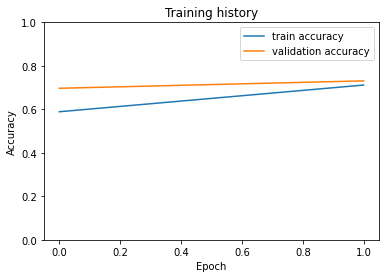

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
class AmazonDataset_test(Dataset):

  def __init__(self,ids, sentences, tokenizer, max_length):
    self.sentences = sentences
    self.ids = ids
    self.tokenizer = tokenizer
    self.max_length = max_length
  
  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, idx):
    sentence = str(self.sentences[idx])
    encoding = self.tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      max_length=self.max_length,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )


    return {
        'sentence': sentence,
        'id':self.ids[idx],
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
    }

In [ ]:
ds_test = AmazonDataset_test(
        sentences =test_df['TITLE'].values,
        ids = test_df['PRODUCT_ID'].values,
        tokenizer=tokenizer,
        max_length=max_input_length,
    )
test_loader = DataLoader(
        ds_test,
        batch_size=batch_size
    )

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  ids = []
  sentences = []
  predictions = []
  prediction_probs = []
  #real_values = []

  with torch.no_grad():
    for i,d in enumerate(data_loader):
      if i%100 == 0:
        print(f"Processing batch {i+1}/{len(data_loader)}")

      sents = d["sentence"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      id = d['id'].detach().cpu().numpy()
    #   labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = torch.nn.functional.softmax(outputs, dim=1)

      sentences.extend(sents)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      ids.extend(id)
    #   real_values.extend(labels)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
#   real_values = torch.stack(real_values).cpu()
  return ids,sentences, predictions, prediction_probs,# real_values

In [ ]:
ids,sents,predictions,prediction_probs = get_predictions(model,test_loader)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Processing batch 1/1731
Processing batch 101/1731
Processing batch 201/1731
Processing batch 301/1731
Processing batch 401/1731
Processing batch 501/1731
Processing batch 601/1731
Processing batch 701/1731
Processing batch 801/1731
Processing batch 901/1731
Processing batch 1001/1731
Processing batch 1101/1731
Processing batch 1201/1731
Processing batch 1301/1731
Processing batch 1401/1731
Processing batch 1501/1731
Processing batch 1601/1731
Processing batch 1701/1731


In [ ]:
df_sub = pd.DataFrame({
    'PRODUCT_ID':ids,
    'BROWSE_NODE_ID':le.inverse_transform(predictions)
})
df_sub

,PRODUCT_ID,BROWSE_NODE_ID
0,1,1140
1,2,3329
2,3,4894
3,4,125
4,5,8915
...,...,...
110770,110771,4368
110771,110772,13568
110772,110773,13568
110773,110774,800


In [ ]:
df_sub.to_csv('/content/drive/MyDrive/AmazonMLChallenge/submission_bert3.csv',index=False)

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/AmazonMLChallenge/model_bert_3.pth')